# Amazon Bin Challenge

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [2]:
from fastai import *
from fastai.vision import *

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [3]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

In [4]:
path = 'aws-bin'
path_img = 'aws-bin/images'

In [5]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('aws-bin/images/24100.jpg'),
 PosixPath('aws-bin/images/30000.jpg'),
 PosixPath('aws-bin/images/32600.jpg'),
 PosixPath('aws-bin/images/31700.jpg'),
 PosixPath('aws-bin/images/19500.jpg')]

In [6]:
data = ImageDataBunch.from_csv('aws-bin', folder='images', csv_labels='labels.csv', 
                               suffix='.jpg', ds_tfms=get_transforms(), size=64)
data.normalize(imagenet_stats)

ImageDataBunch;
Train: LabelList
y: CategoryList (327 items)
[Category 2, Category 2, Category 3, Category 3, Category 4]...
Path: .
x: ImageItemList (327 items)
[Image (3, 335, 565), Image (3, 294, 494), Image (3, 321, 541), Image (3, 313, 527), Image (3, 548, 576)]...
Path: aws-bin;
Valid: LabelList
y: CategoryList (81 items)
[Category 10, Category 1, Category 4, Category 4, Category 3]...
Path: .
x: ImageItemList (81 items)
[Image (3, 267, 390), Image (3, 267, 391), Image (3, 341, 444), Image (3, 519, 597), Image (3, 482, 651)]...
Path: aws-bin;
Test: None

In [21]:
data = (ImageItemList.from_csv(path=Path('aws-bin'), csv_name='labels.csv', folder='images', suffix='.jpg')
        #Where to find the data? -> in planet 'train' folder
        .random_split_by_pct()
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_df(cols='label', label_cls=FloatList)
        #How to label? -> use the csv file
        .transform(get_transforms(), size=224)
        #Data augmentation? -> use tfms with a size of 128
        .databunch())                          
        #Finally -> use the defaults for conversion to databunch
data.normalize(imagenet_stats)    

ImageDataBunch;
Train: LabelList
y: FloatList (327 items)
[FloatItem 2.0, FloatItem 2.0, FloatItem 3.0, FloatItem 3.0, FloatItem 4.0]...
Path: .
x: ImageItemList (327 items)
[Image (3, 335, 565), Image (3, 294, 494), Image (3, 321, 541), Image (3, 313, 527), Image (3, 330, 554)]...
Path: aws-bin;
Valid: LabelList
y: FloatList (81 items)
[FloatItem 8.0, FloatItem 5.0, FloatItem 5.0, FloatItem 7.0, FloatItem 4.0]...
Path: .
x: ImageItemList (81 items)
[Image (3, 373, 485), Image (3, 556, 575), Image (3, 552, 580), Image (3, 304, 511), Image (3, 548, 576)]...
Path: aws-bin;
Test: None

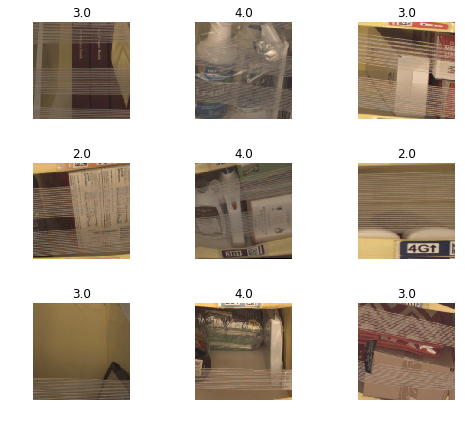

In [22]:
data.show_batch(rows=3, figsize=(7,6))

In [15]:
df = pd.read_csv('aws-bin/labels.csv')
df.head()

,name,label
0,500,2
1,600,2
2,700,3
3,800,3
4,900,4


## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [24]:
learn = create_cnn(data, models.resnet34, metrics=exp_rmspe)
#learn.loss_func = MSELossFlat()

In [25]:
learn.fit_one_cycle(4)

Total time: 00:16
epoch  train_loss  valid_loss  exp_rmspe
1      38.046322   64.568764   0.929986   (00:05)
2      43.213657   59.238895   1.392429   (00:04)
3      37.738602   51.783939   4.646130   (00:03)
4      34.576664   49.296467   4.406271   (00:03)



In [26]:
learn.save('stage-1')

In [31]:
learn.unfreeze()

In [32]:
learn.fit_one_cycle(1)

Total time: 00:04
epoch  train_loss  valid_loss  exp_rmspe
1      35.145615   86.962769   1.146731   (00:04)



In [33]:
learn.load('stage-1')

Learner(data=ImageDataBunch;
Train: LabelList
y: FloatList (327 items)
[FloatItem 2.0, FloatItem 2.0, FloatItem 3.0, FloatItem 3.0, FloatItem 4.0]...
Path: .
x: ImageItemList (327 items)
[Image (3, 335, 565), Image (3, 294, 494), Image (3, 321, 541), Image (3, 313, 527), Image (3, 330, 554)]...
Path: aws-bin;
Valid: LabelList
y: FloatList (81 items)
[FloatItem 8.0, FloatItem 5.0, FloatItem 5.0, FloatItem 7.0, FloatItem 4.0]...
Path: .
x: ImageItemList (81 items)
[Image (3, 373, 485), Image (3, 556, 575), Image (3, 552, 580), Image (3, 304, 511), Image (3, 548, 576)]...
Path: aws-bin;
Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, ke

In [34]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


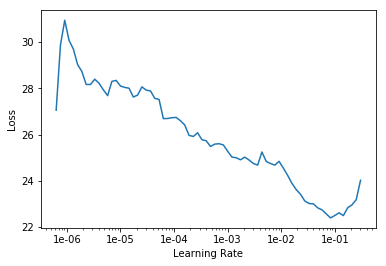

In [35]:
learn.recorder.plot()

In [36]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-4,1e-3))

Total time: 00:08
epoch  train_loss  valid_loss  exp_rmspe 
1      25.166206   75.530907   11.063832   (00:04)
2      23.564043   51.392082   139.477829  (00:04)



That's a pretty accurate model!

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [7]:
learn = create_cnn(data, models.resnet50)

In [8]:
learn.fit_one_cycle(8)

Total time: 00:19
epoch  train_loss  valid_loss
1      3.713144    3.242492    (00:04)
2      3.571156    3.109020    (00:02)
3      3.541100    3.122214    (00:02)
4      3.428954    3.296061    (00:02)
5      3.301070    3.192260    (00:02)
6      3.189596    3.107843    (00:02)
7      3.105649    3.118076    (00:02)
8      3.017011    3.075896    (00:02)



In [10]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [11]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-4,1e-3))

Total time: 00:08
epoch  train_loss  valid_loss
1      2.745181    3.326039    (00:03)
2      2.595416    3.524325    (00:02)
3      2.555964    3.241251    (00:02)



# Test It Out

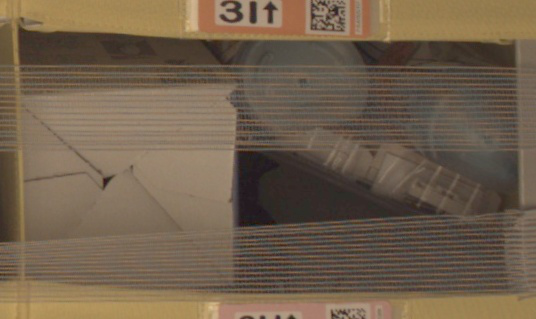

In [24]:
img = open_image('aws-bin/images/24100.jpg')
img

In [25]:
learn.predict(img)[0]

5

## Nice!